# Preparations

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import geopy.distance as distance
import data_analysis
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt

In [41]:
def plotregion(m, df, linecolor="#00ff00"):
    df = df.dropna(subset=["temp", "humidity"])
    line = df[["lat", "lon"]].values
    if len(line):
        folium.PolyLine(line, color=linecolor).add_to(m)

    for lat, lon, temp, humidity, distance, fixtype in df[
        ["lat", "lon", "temp", "humidity", "distance", 'fixtype']
    ].values:
        # color = f'#{int(temp / 20 * 256):02x}00{int(humidity / 100 * 256):02x}'
        # color = f'#{int(distance / 151 * 255):02x}00{int((1 - distance / 151) * 255):02x}'
        # color = 'black'
        color = 'orange' if fixtype == 'DGPS' else 'blue' if fixtype == 'GPS' else 'white'
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            fill_opacity=1,
            fill=True,
            stroke=False,
            color=color
        ).add_to(m)

# Sanity Checks

In [56]:
m = folium.Map(
    tiles="Stadia.AlidadeSatellite",
    location=[42.446, -78.2155],
    zoom_start=18,
    zoom_control=False,
)
dates = ["04-04"]
all_ground = []
all_below_samples = []
all_above = []
for date in dates:
    for transect in range(1, 4):
        ground = data_analysis.ground_data(transect, date)
        below = data_analysis.below_canopy(transect, date)
        above = data_analysis.above_canopy(transect, date)

        below_samples = data_analysis.get_distances(ground, below, above)
        all_ground.append(ground)
        all_below_samples.append(below_samples)
        all_above.append(above)
        plotregion(m, below_samples, linecolor="gold")
        plotregion(m, above, linecolor="purple")
all_ground = pd.concat(all_ground, axis=0)
all_below_samples = pd.concat(all_below_samples, axis=0)
all_above = pd.concat(all_above, axis=0)
m

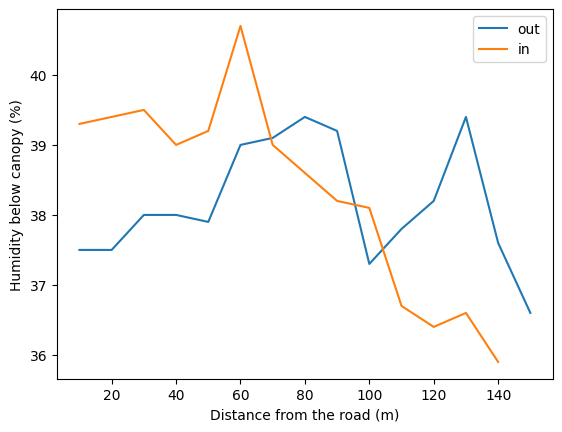

In [4]:
ground = data_analysis.ground_data(1, "04-04")
below = data_analysis.below_canopy(1, "04-04")
above = data_analysis.above_canopy(1, "04-04")
below_samples = data_analysis.get_distances(ground, below, above)
sns.lineplot(below_samples, x="distance", y="humidity", hue="direction")
plt.xlabel("Distance from the road (m)")
plt.ylabel("Humidity below canopy (%)")
plt.legend(title=False);

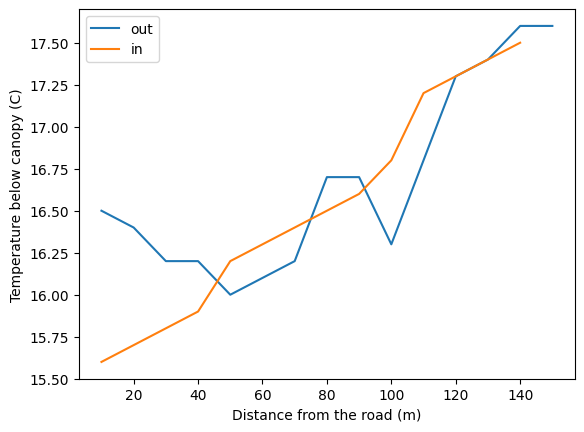

In [5]:
sns.lineplot(below_samples, x="distance", y="temp", hue="direction")
plt.xlabel("Distance from the road (m)")
plt.ylabel("Temperature below canopy (C)")
plt.legend(title=False);

/tmp/ipykernel_17180/2786873545.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  below_samples.query("distance < 150").groupby("distance").apply(


Text(0, 0.5, 'Return Error (m)')

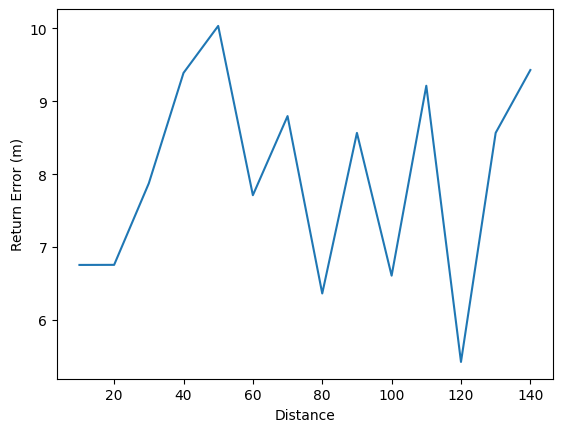

In [6]:
below_samples.query("distance < 150").groupby("distance").apply(
    lambda g: distance.distance(*g[["lat", "lon"]].values).meters
).plot()
plt.xlabel("Distance")
plt.ylabel("Return Error (m)")

# GPS tests

In [57]:
transect = 1
date = '04-04'
ground = data_analysis.ground_data(transect, date)
below = data_analysis.below_canopy(transect, date)
above = data_analysis.above_canopy(transect, date)
below_samples = data_analysis.get_distances(ground, below, above);

In [ ]:
ax = sns.scatterplot(below_samples, x='distance', y='satellites')
sns.scatterplot(above, x='distance', y='satellites', ax=ax);

# Combine Data

In [7]:
merged = data_analysis.merge(
    data_analysis.combine_data(all_below_samples),
    data_analysis.combine_data(all_above),
    ("_below", "_above"),
)

In [8]:
all_data = data_analysis.merge(
    all_ground.groupby(["date", "transect", "distance"]).apply(
        lambda g: g.iloc[0][["soil_temperature", "soil_moisture"]]
    ),
    merged,
    ("_ground", ""),
)

/tmp/ipykernel_17180/318711997.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_ground.groupby(["date", "transect", "distance"]).apply(


# Tests

## 1 Tests

In [9]:
stats.bartlett(
    *all_data[["soil_temperature", "temp_below", "temp_above"]].values.T,
    nan_policy="omit"
)

BartlettResult(statistic=np.float64(169.2643221828394), pvalue=np.float64(1.7567883647994039e-37))

In [10]:
stats.f_oneway(
    *all_data[["soil_temperature", "temp_below", "temp_above"]].values.T,
    nan_policy="omit"
)

F_onewayResult(statistic=np.float64(188.5326318220938), pvalue=np.float64(6.64808462230999e-38))

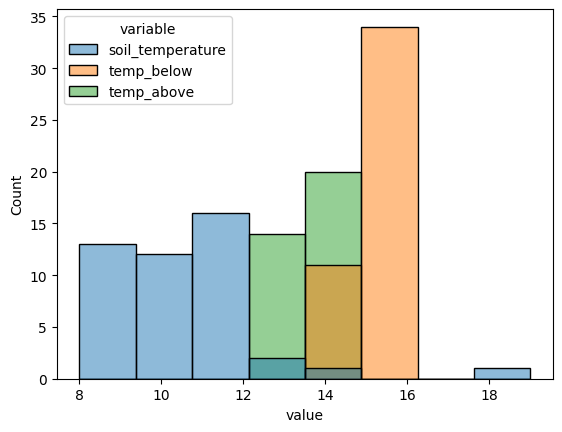

In [11]:
sns.histplot(
    all_data.melt(value_vars=["soil_temperature", "temp_below", "temp_above"]),
    x="value",
    hue="variable",
);

In [12]:
stats.bartlett(
    *all_data[["humidity_below", "humidity_above"]].values.T, nan_policy="omit"
)

BartlettResult(statistic=np.float64(53.58845713013538), pvalue=np.float64(2.472076020007805e-13))

In [13]:
stats.f_oneway(
    *all_data[["humidity_below", "humidity_above"]].values.T, nan_policy="omit"
)

F_onewayResult(statistic=np.float64(16.92138925171699), pvalue=np.float64(9.675969180930189e-05))

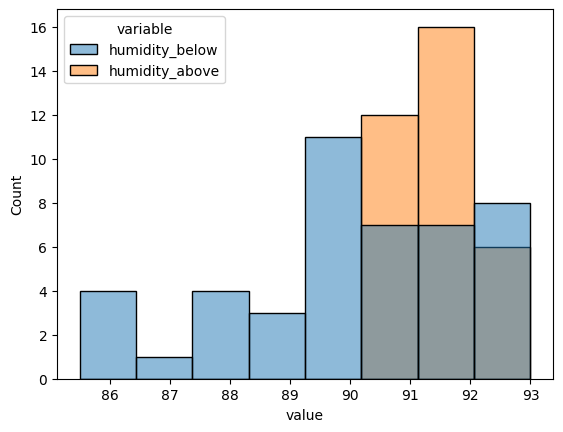

In [14]:
sns.histplot(
    all_data.melt(value_vars=["humidity_below", "humidity_above"]),
    x="value",
    hue="variable",
);

## 2 Tests

In [15]:
all_data.dropna(inplace=True)

In [16]:
stats.pearsonr(*all_data[["temp_below", "temp_above"]].values.T)

PearsonRResult(statistic=np.float64(-0.425358870088142), pvalue=np.float64(0.012146172561487293))

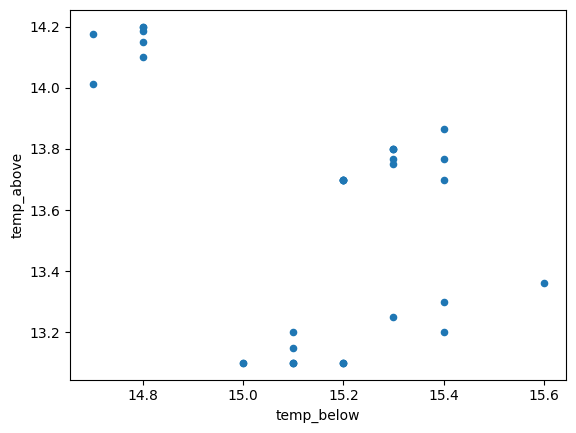

In [17]:
all_data.plot.scatter(x="temp_below", y="temp_above");

In [18]:
stats.pearsonr(*all_data[["soil_temperature", "temp_below"]].values.T)

PearsonRResult(statistic=np.float64(0.46268771480144066), pvalue=np.float64(0.005863679701339121))

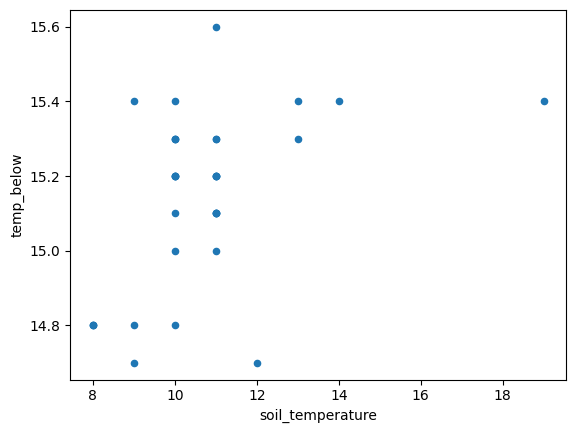

In [19]:
all_data.plot.scatter(x="soil_temperature", y="temp_below");

In [20]:
stats.pearsonr(*all_data[["humidity_below", "humidity_above"]].values.T)

PearsonRResult(statistic=np.float64(-0.42164035556811275), pvalue=np.float64(0.013004975125193687))

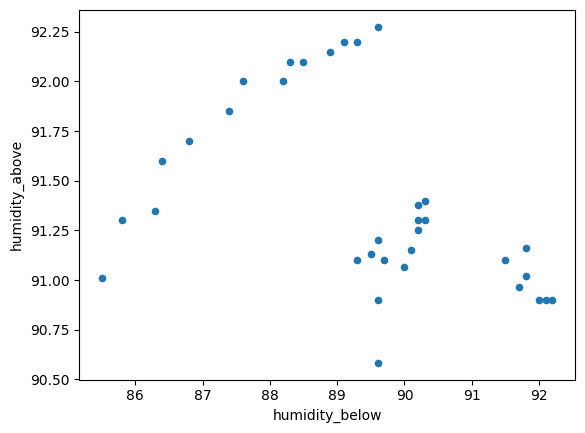

In [21]:
all_data.plot.scatter(x="humidity_below", y="humidity_above");

In [22]:
stats.pearsonr(*all_data[["humidity_below", "soil_moisture"]].values.T)

PearsonRResult(statistic=np.float64(0.4517105973105636), pvalue=np.float64(0.007324279799768262))

## 3 Tests

### Temperature

In [23]:
stats.pearsonr(*all_ground[["distance", "soil_temperature"]].values.T)

PearsonRResult(statistic=np.float64(-0.2411136876619884), pvalue=np.float64(0.11058589036679366))

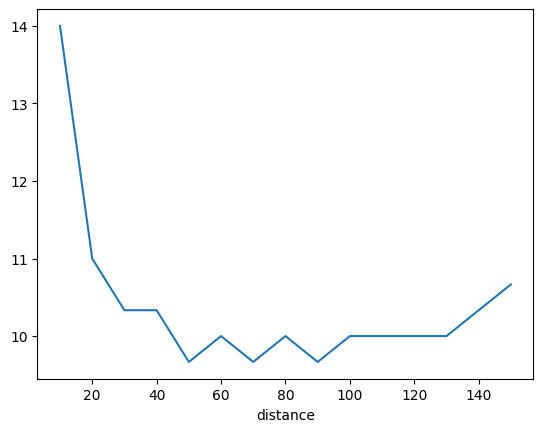

In [24]:
all_ground.groupby("distance")["soil_temperature"].mean().plot();

In [25]:
stats.pearsonr(*all_below_samples[["distance", "temp"]].values.T)

PearsonRResult(statistic=np.float64(-0.22605696771320188), pvalue=np.float64(0.13539315460644827))

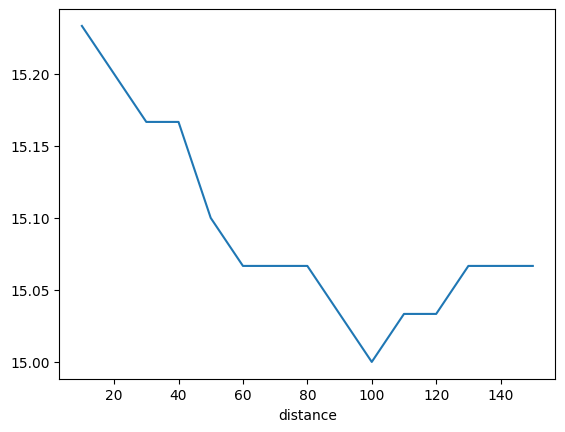

In [26]:
all_below_samples.groupby("distance")["temp"].mean().plot();

In [27]:
stats.pearsonr(*all_above[["distance", "temp"]].values.T)

PearsonRResult(statistic=np.float64(-0.2987203002962293), pvalue=np.float64(0.0018684045415425057))

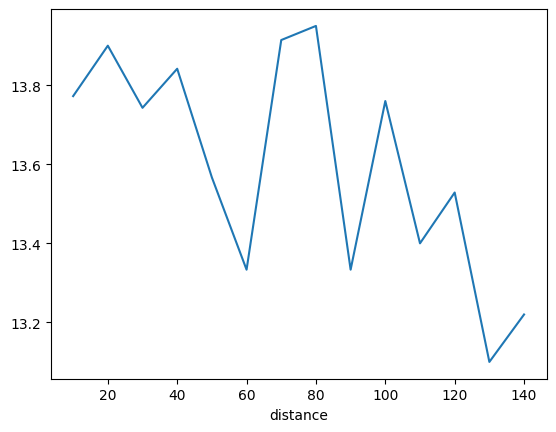

In [28]:
all_above.groupby("distance")["temp"].mean().plot();

### Humidity

In [29]:
stats.pearsonr(*all_ground[["distance", "soil_moisture"]].values.T)

PearsonRResult(statistic=np.float64(0.12495954320897888), pvalue=np.float64(0.4134265965697407))

In [30]:
stats.pearsonr(*all_below_samples[["distance", "humidity"]].values.T)

PearsonRResult(statistic=np.float64(0.3448790016949304), pvalue=np.float64(0.020335402917462067))

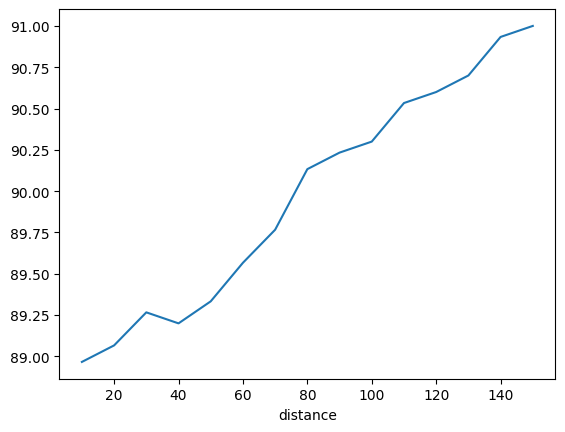

In [31]:
all_below_samples.groupby("distance")["humidity"].mean().plot();

In [32]:
stats.pearsonr(*all_above[["distance", "humidity"]].values.T)

PearsonRResult(statistic=np.float64(0.6468977480674758), pvalue=np.float64(6.815736325227642e-14))

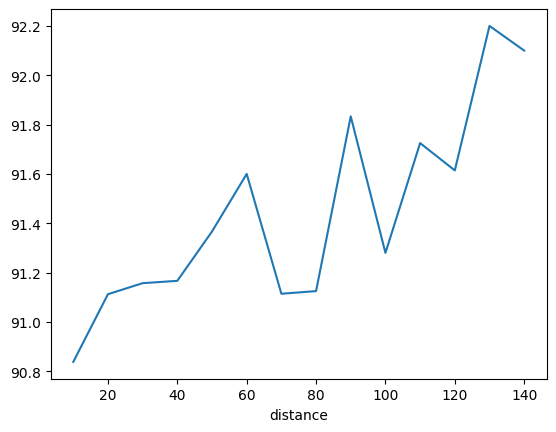

In [33]:
all_above.groupby("distance")["humidity"].mean().plot();

## 4 Tests

In [34]:
all_data.eval("temp_above_below = temp_above - temp_below", inplace=True)
all_data.eval(
    "temp_below_ground = temp_below - soil_temperature", inplace=True
)
all_data.eval(
    "temp_above_ground = temp_above - soil_temperature", inplace=True
)
all_data.eval(
    "humidity_above_below = humidity_above - humidity_below", inplace=True
)
all_data.reset_index(inplace=True)

PearsonRResult(statistic=np.float64(-0.1382436525456735), pvalue=np.float64(0.4355701014051266))

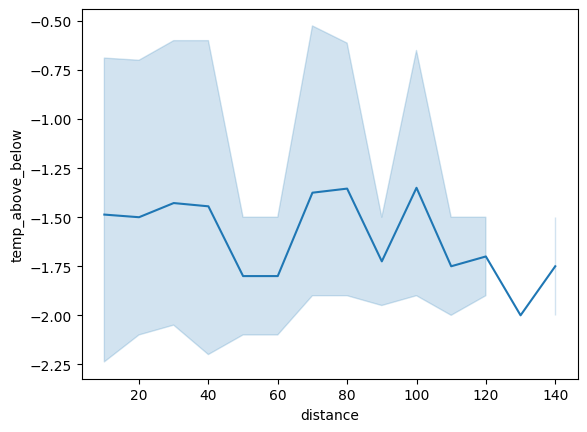

In [35]:
sns.lineplot(all_data, x="distance", y="temp_above_below")
stats.pearsonr(*all_data[["distance", "temp_above_below"]].values.T)

PearsonRResult(statistic=np.float64(0.23553564204745236), pvalue=np.float64(0.17992621596611721))

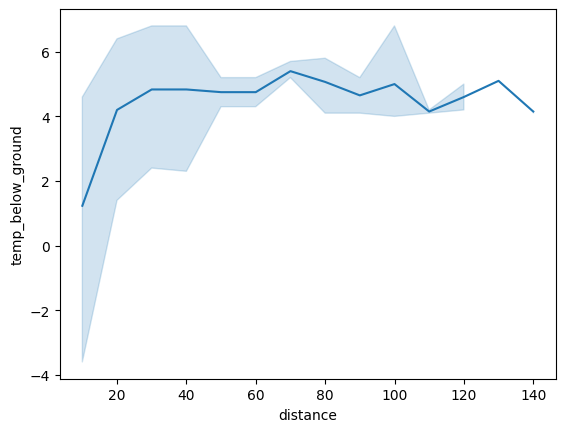

In [36]:
sns.lineplot(all_data, x="distance", y="temp_below_ground")
stats.pearsonr(*all_data[["distance", "temp_below_ground"]].values.T)

PearsonRResult(statistic=np.float64(0.1812051082606155), pvalue=np.float64(0.3050808050955312))

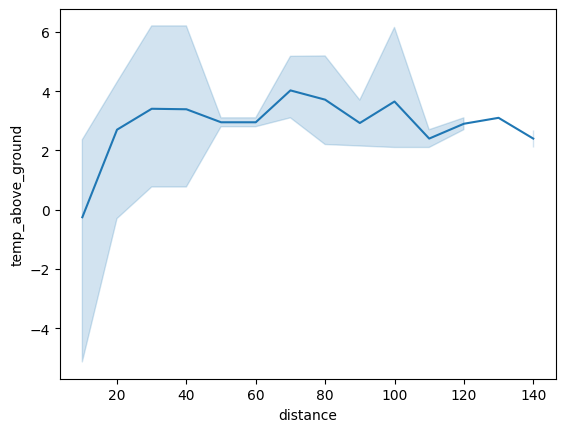

In [37]:
sns.lineplot(all_data, x="distance", y="temp_above_ground")
stats.pearsonr(*all_data[["distance", "temp_above_ground"]].values.T)

PearsonRResult(statistic=np.float64(-0.028295660847026748), pvalue=np.float64(0.8737863557237524))

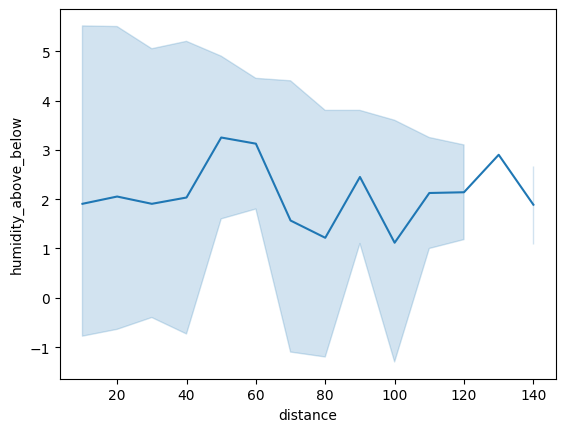

In [38]:
sns.lineplot(all_data, x="distance", y="humidity_above_below")
stats.pearsonr(*all_data[["distance", "humidity_above_below"]].values.T)